In [ ]:
import os
import collections
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio


In [2]:
def pretty_dict(ndict, indent=0, print_type=False):
    """Visualizes the tree-like structure of a dictionary
    Arguments:
        ndict {dict} -- [the python dictionary to be visualized]
    Keyword Arguments:
        indent {int} -- [number of tab spaces for the indentation]
        (default: {0})
        print_type {bool} -- [True if variable types are printed]
        (default: {False})
    """
    if isinstance(ndict, dict):
        for key, value in ndict.items():
            if print_type:
                print(
                    "\t" * indent + "Key: " + str(key) + ",\t" + "Type: ", type(value),
                )
                pretty_dict(value, indent + 1, True)
            else:
                print("\t" * indent + "Key: " + str(key))
                pretty_dict(value, indent + 1)


In [3]:
def mat2dict(filename):
    """Converts MoVi mat files to a python nested dictionary.
    This makes a cleaner representation compared to sio.loadmat
    Arguments:
        filename {str} -- The path pointing to the .mat file which contains
        MoVi style mat structs
    Returns:
        dict -- A nested dictionary similar to the MoVi style MATLAB struct
    """
    # Reading MATLAB file
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)

    # Converting mat-objects to a dictionary
    for key in data:
        if key != "__header__" and key != "__global__" and key != "__version__":
            if isinstance(data[key], sio.matlab.mio5_params.mat_struct):
                data_out = matobj2dict(data[key])
    return data_out

In [4]:
def matobj2dict(matobj):
    """A recursive function which converts nested mat object
    to a nested python dictionaries
    Arguments:
        matobj {sio.matlab.mio5_params.mat_struct} -- nested mat object
    Returns:
        dict -- a nested dictionary
    """
    ndict = {}
    for fieldname in matobj._fieldnames:
        attr = matobj.__dict__[fieldname]
        if isinstance(attr, sio.matlab.mio5_params.mat_struct):
            ndict[fieldname] = matobj2dict(attr)
        elif isinstance(attr, np.ndarray) and fieldname == "move":
            for ind, val in np.ndenumerate(attr):
                ndict[
                    fieldname
                    + str(ind).replace(",", "").replace(")", "").replace("(", "_")
                ] = matobj2dict(val)
        elif fieldname == "skel":
            tree = []
            for ind in range(len(attr)):
                tree.append(matobj2dict(attr[ind]))
            ndict[fieldname] = tree
        else:
            ndict[fieldname] = attr
    return ndict

In [5]:
# Converting dictionary to namedTuple
def dict2ntuple(ndict):
    """Converts nested (or simple) dictionary to namedTuples
    so that the attributes are accessible by dotted notation.
    Example: subj = mat2dicts(matefilename)
    subj = subj('Subject_15')
    n_subj = dict2ntuple(subj)
    IMU = n_subj.IMU
    Arguments:
        ndict {dict}: python dictionary to be converted to a
        namecTuple. Make sure all keys are made by letters or
        underscore (key names must not by prefixed with underscore)
    Returns:
        namedTuple -- a nested namedTuple object
    """

    if isinstance(ndict, collections.Mapping) and not isinstance(ndict, ProtectedDict):
        for key, value in ndict.items():
            ndict[key] = dict2ntuple(value)
        return dict2tuple(ndict)
    return ndict

In [22]:
imu_filename = 'imu_Subject_1.csv'

In [23]:
# Reading MoVi files as a Python dictionary
sample = mat2dict(imu_filename)

FileNotFoundError: [Errno 2] No such file or directory: '\\MoVi\\IMUmatlab_Subject_1_15\\imu_Subject_1.mat'

In [9]:
sample.keys()

dict_keys(['S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'])

In [10]:
pretty_dict(sample, print_type=False, indent=1)

	Key: S1_Synched
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
		Key: delay
		Key: scale
	Key: S2_Synched
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
		Key: delay
		Key: scale
	Key: I1
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
	Key: I2
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
	Key: S1
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
	Key: S2
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescript

In [11]:
# Nome das juntas onde estão os sensores
sample['S2_Synched']['jointNames']

array(['Hip', 'RightUpLeg', 'RightLeg', 'RightFoot', 'LeftUpLeg',
       'LeftLeg', 'LeftFoot', 'RightShoulder', 'RightArm', 'RightForeArm',
       'RightHand', 'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand',
       'Head', 'Neck', 'Spine3', 'Spine2', 'Spine1', 'Spine'],
      dtype=object)

In [12]:
# Número das juntas onde estão os sensores
sample['S2_Synched']['jointNumbers']

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'],
      dtype=object)

In [13]:
# Tipos de dados para cada sensor
print(sample['S2_Synched']['dataTypes'])
print("['Displacement(meter)'],['Speed (meter per second)'],['Posture data (Quaternions)'],(['Acceleration (g)']")
print("['Angular velocity (radian per second)']")

['X' 'V' 'Q' 'A' 'W']
['Displacement(meter)'],['Speed (meter per second)'],['Posture data (Quaternions)'],(['Acceleration (g)']
['Angular velocity (radian per second)']


In [14]:
Data = sample['S2_Synched']['data']

In [15]:
dataHeader_filename = 'dataHeader.mat'
dataHeader = sio.loadmat(dataHeader_filename)
pretty_dict(dataHeader, print_type=False, indent=1)

	Key: __header__
	Key: __version__
	Key: __globals__
	Key: None
	Key: __function_workspace__


In [16]:
dataHeader['None']

MatlabOpaque([(b'x', b'MCOS', b'string', array([[3707764736],
       [         2],
       [         1],
       [         1],
       [         1],
       [         1]], dtype=uint32))],
             dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')])

In [17]:
header = pd.read_csv('columns.csv', sep=';')
header = header[:].values.tolist()

In [18]:
data = pd.DataFrame(Data, columns=header)
data.head()

,01-X-x,01-X-y,01-X-z,01-V-x,01-V-y,01-V-z,01-Q-s,01-Q-x,01-Q-y,01-Q-z,...,21-Q-s,21-Q-x,21-Q-y,21-Q-z,21-A-x,21-A-y,21-A-z,21-W-x,21-W-y,21-W-z
0,0.031078,0.056503,-0.0118,-0.011616,0.000556,0.007377,-0.123424,0.705,0.137418,0.684787,...,1.0,0.0,0.0,0.0,-0.981378,0.003906,0.237357,-0.016800,1.577233e-12,0.001291
1,0.030993,0.056499,-0.0118,-0.012510,0.001541,0.007329,-0.123510,0.705,0.137535,0.684687,...,1.0,0.0,0.0,0.0,-0.985008,0.003877,0.234089,-0.018674,-4.283233e-13,-0.005389
2,0.030984,0.056501,-0.0118,-0.013123,0.002509,0.007103,-0.123497,0.705,0.137608,0.684704,...,1.0,0.0,0.0,0.0,-0.983369,0.003989,0.234174,-0.012947,1.161375e-13,-0.014780
3,0.030861,0.056498,-0.0118,-0.012298,-0.001319,0.007391,-0.123500,0.705,0.137598,0.684699,...,1.0,0.0,0.0,0.0,-0.979803,0.003554,0.235767,0.001808,-3.144365e-14,0.002313
4,0.030797,0.056507,-0.0118,-0.013124,0.000015,0.007484,-0.123502,0.705,0.137601,0.684700,...,1.0,0.0,0.0,0.0,-0.981956,0.005350,0.237266,-0.000481,8.501267e-15,-0.000654


In [19]:
data_01 = data.iloc[500:1200,:16]
data_01.head()

,01-X-x,01-X-y,01-X-z,01-V-x,01-V-y,01-V-z,01-Q-s,01-Q-x,01-Q-y,01-Q-z,01-A-x,01-A-y,01-A-z,01-W-x,01-W-y,01-W-z
500,0.021125,0.050423,-0.012470,0.001051,0.003724,0.007532,-0.121388,0.709799,0.136588,0.680302,-0.984813,0.002748,0.219240,3.047638e-10,-0.017171,-0.000596
501,0.021204,0.050512,-0.012415,0.000837,0.003683,0.007374,-0.121403,0.709806,0.136602,0.680294,-0.984486,0.000575,0.218403,-8.294836e-11,-0.018818,0.000162
502,0.021223,0.050491,-0.012513,0.002077,0.004584,0.007244,-0.121399,0.709774,0.136605,0.680326,-0.983515,0.004386,0.220079,2.320634e-11,-0.011961,-0.000044
503,0.021313,0.050528,-0.012497,0.003836,0.004523,0.007295,-0.121401,0.709690,0.136573,0.680410,-0.979746,0.003849,0.222048,-9.047347e-12,-0.002591,0.000012
504,0.021290,0.050610,-0.012499,0.000600,0.003618,0.007659,-0.121398,0.709703,0.136489,0.680397,-0.982037,0.003604,0.218284,1.311203e-11,-0.020995,-0.000003


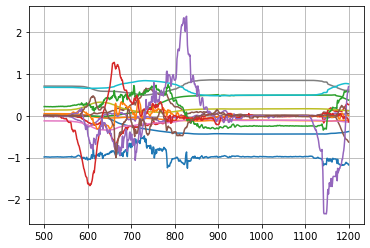

In [20]:
plt.plot(data_01.index, data_01.values)
plt.grid()
plt.show()

In [21]:
data_01_X = data.iloc[500:1200,:3]
data_01_X.head()

,01-X-x,01-X-y,01-X-z
500,0.021125,0.050423,-0.012470
501,0.021204,0.050512,-0.012415
502,0.021223,0.050491,-0.012513
503,0.021313,0.050528,-0.012497
504,0.021290,0.050610,-0.012499


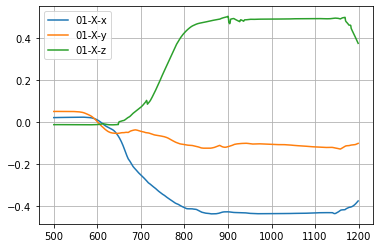

In [22]:
plt.plot(data_01_X.index, data_01_X.values)
plt.grid()
plt.legend(('01-X-x',
  '01-X-y',
  '01-X-z'))
plt.show()

In [23]:
data_01_V = data.iloc[500:1200,3:6]
data_01_V.head()

,01-V-x,01-V-y,01-V-z
500,0.001051,0.003724,0.007532
501,0.000837,0.003683,0.007374
502,0.002077,0.004584,0.007244
503,0.003836,0.004523,0.007295
504,0.000600,0.003618,0.007659


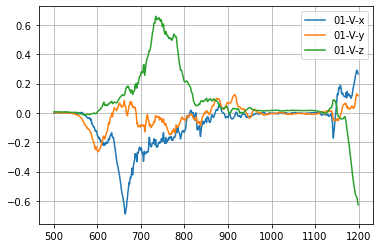

In [24]:
plt.plot(data_01_V.index, data_01_V.values)
plt.grid()
plt.legend(('01-V-x',
  '01-V-y',
  '01-V-z'))
plt.show()

In [25]:
data_01_Q = data.iloc[500:1200,6:10]
data_01_Q.head()

,01-Q-s,01-Q-x,01-Q-y,01-Q-z
500,-0.121388,0.709799,0.136588,0.680302
501,-0.121403,0.709806,0.136602,0.680294
502,-0.121399,0.709774,0.136605,0.680326
503,-0.121401,0.709690,0.136573,0.680410
504,-0.121398,0.709703,0.136489,0.680397


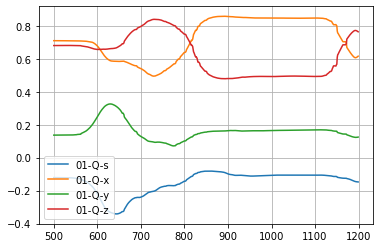

In [26]:
plt.plot(data_01_Q.index, data_01_Q.values)
plt.grid()
plt.legend(('01-Q-s',
  '01-Q-x',
  '01-Q-y',
  '01-Q-z'))
plt.show()

In [27]:
data_01_A = data.iloc[500:1200,10:13]
data_01_A.head()

,01-A-x,01-A-y,01-A-z
500,-0.984813,0.002748,0.219240
501,-0.984486,0.000575,0.218403
502,-0.983515,0.004386,0.220079
503,-0.979746,0.003849,0.222048
504,-0.982037,0.003604,0.218284


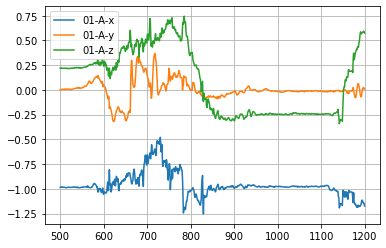

In [28]:
plt.plot(data_01_A.index, data_01_A.values)
plt.grid()
plt.legend(('01-A-x',
  '01-A-y',
  '01-A-z'))
plt.show()

In [29]:
data_01_W = data.iloc[500:1200,13:16]
data_01_W.head()

,01-W-x,01-W-y,01-W-z
500,3.047638e-10,-0.017171,-0.000596
501,-8.294836e-11,-0.018818,0.000162
502,2.320634e-11,-0.011961,-0.000044
503,-9.047347e-12,-0.002591,0.000012
504,1.311203e-11,-0.020995,-0.000003


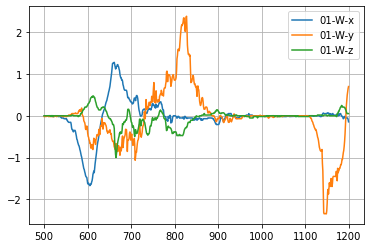

In [30]:
plt.plot(data_01_W.index, data_01_W.values)
plt.grid()
plt.legend(('01-W-x',
  '01-W-y',
  '01-W-z'))
plt.show()